In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

In [2]:
# ADICIONAR ETAPA DO MinIO
path = '/home/ricardo/Documentos/git/SVMSquad/ProjSquadStack/olistcsv/'
raw_price_freight = pd.read_csv(path + 'olist_order_items_dataset.csv')
raw_payment = pd.read_csv(path + 'olist_order_payments_dataset.csv')
raw_client_review = pd.read_csv(path + 'olist_order_reviews_dataset.csv')
raw_orders_central = pd.read_csv(path + 'olist_orders_dataset.csv')
raw_costumer = pd.read_csv(path + 'olist_customers_dataset.csv')

In [3]:
# Formação de tabelas e seus vínculos explicativos

df1 = pd.merge(left=raw_orders_central, right=raw_costumer, on='customer_id', how='outer')
price_freight = pd.merge(left=raw_price_freight, right=df1, on='order_id', how='left')
payment = pd.merge(left=raw_payment, right=df1, on='order_id', how='left')
client_review = pd.merge(left=raw_client_review, right=df1, on='order_id', how='left')

In [4]:
del raw_client_review, raw_costumer, raw_orders_central, raw_payment, raw_price_freight

In [5]:
def transform(df: pd.DataFrame, colunas: list) -> pd.DataFrame:
    for each in colunas:
        df[each] = pd.to_datetime(df[each], errors='coerce')
    df['customer_zip_code_prefix'].astype('object')

In [6]:
# Tabela client_review
colunas = ('review_creation_date review_answer_timestamp order_purchase_timestamp order_approved_at ' +
'order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date').split()

transform(client_review, colunas)


# Tabela payment 
colunas = ('order_purchase_timestamp order_approved_at order_delivered_carrier_date'
          + ' order_delivered_customer_date order_estimated_delivery_date').split()

transform(payment, colunas)


# Tabela price_freight
colunas = ('shipping_limit_date order_purchase_timestamp order_approved_at order_delivered_carrier_date'
          + ' order_delivered_customer_date order_estimated_delivery_date').split()

transform(price_freight, colunas)

In [7]:
del colunas

In [8]:
Cliente = price_freight[['customer_unique_id', 'order_id']].groupby(['customer_unique_id']).agg(['nunique','count']).sort_values([('order_id', 'count'), ('order_id', 'nunique')], ascending=False)

In [9]:
Cliente = Cliente['order_id']['nunique'].sort_values(ascending=False)

In [10]:
p2 = price_freight[['customer_unique_id', 'order_purchase_timestamp']].groupby(['customer_unique_id'], as_index=False).agg(['max', 'min'])['order_purchase_timestamp']
p2['time'] = p2['max'] - p2['min']
p2 = p2.reset_index()
p2.time[p2.time < timedelta(days=1)] = timedelta(days=1)

/tmp/ipykernel_3326/3696437222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p2.time[p2.time < timedelta(days=1)] = timedelta(days=1)


In [11]:
Cliente = pd.merge(left=Cliente, right=p2[['customer_unique_id', 'time']], how='outer', on='customer_unique_id').sort_values('time', ascending=False)

In [12]:
p2['recencia'] = np.array([datetime.today() for _ in range(p2['max'].shape[0])], dtype=np.datetime64) - p2['max']
Cliente = pd.merge(left=Cliente, right=p2[['customer_unique_id', 'recencia']], how='outer', on='customer_unique_id').sort_values('time', ascending=False)

In [13]:
Cliente.columns = 'cliente quantia_comprada retencao recencia'.split()

In [14]:
p1 = price_freight[['customer_unique_id', 'price', 'freight_value']].groupby('customer_unique_id', as_index=False).sum() #.groupby()
p1['receita_total_por_cliente'] = p1.price + p1.freight_value
Cliente = pd.merge(left=Cliente, right=p1[['customer_unique_id', 'receita_total_por_cliente']], left_on='cliente', right_on='customer_unique_id', how='outer').drop(columns='customer_unique_id')

In [15]:
Cliente

,cliente,quantia_comprada,retencao,recencia,receita_total_por_cliente
0,32ea3bdedab835c3aa6cb68ce66565ef,3,633 days 02:01:14,1311 days 23:22:58.570812,137.16
1,ccafc1c3f270410521c3c6f3b249870f,2,608 days 23:29:38,1332 days 16:05:50.679461,207.51
2,d8f3c4f441a9b59a29f977df16724f38,2,582 days 20:44:41,1254 days 17:16:03.689996,158.51
3,94e5ea5a8c1bf546db2739673060c43f,2,580 days 16:38:23,1361 days 21:19:43.639546,187.17
4,87b3f231705783eb2217e25851c0a45d,2,572 days 16:29:03,1366 days 23:54:25.631759,523.12
...,...,...,...,...,...
95415,42c8ccbe558d063718d19cff01505af9,1,1 days 00:00:00,1673 days 11:51:04.581086,259.96
95416,42c837a3d7df8cfa87de63fbc1aade2f,1,1 days 00:00:00,1285 days 21:44:56.581085,98.90
95417,42c7e57c48d38fc34ed69508a092abcd,1,1 days 00:00:00,1325 days 01:48:41.581082,138.46
95418,42f3aebe1309a0f58863f1ec28898969,1,1 days 00:00:00,1299 days 02:55:31.581184,42.53


In [16]:
Cliente['receita_media_por_quantia'] = Cliente['receita_total_por_cliente']/Cliente['quantia_comprada']
Cliente['receita_media_por_dia'] = Cliente['receita_total_por_cliente']/Cliente['retencao'].dt.days
Cliente.drop(columns='receita_total_por_cliente', inplace=True)
Cliente['retencao'] = Cliente.retencao.dt.days
Cliente['recencia'] = Cliente.recencia.dt.days

In [17]:
Cliente

,cliente,quantia_comprada,retencao,recencia,receita_media_por_quantia,receita_media_por_dia
0,32ea3bdedab835c3aa6cb68ce66565ef,3,633,1311,45.720,0.216682
1,ccafc1c3f270410521c3c6f3b249870f,2,608,1332,103.755,0.341299
2,d8f3c4f441a9b59a29f977df16724f38,2,582,1254,79.255,0.272354
3,94e5ea5a8c1bf546db2739673060c43f,2,580,1361,93.585,0.322707
4,87b3f231705783eb2217e25851c0a45d,2,572,1366,261.560,0.914545
...,...,...,...,...,...,...
95415,42c8ccbe558d063718d19cff01505af9,1,1,1673,259.960,259.960000
95416,42c837a3d7df8cfa87de63fbc1aade2f,1,1,1285,98.900,98.900000
95417,42c7e57c48d38fc34ed69508a092abcd,1,1,1325,138.460,138.460000
95418,42f3aebe1309a0f58863f1ec28898969,1,1,1299,42.530,42.530000


## ETAPA 2:

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.under_sampling import NearMiss
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
X = Cliente.drop(columns='cliente')

In [20]:
X.drop('receita_media_por_dia', axis=1, inplace=True)

In [70]:
scaled_data

,quantia_comprada,retencao,recencia,receita_media_por_quantia
0,0.133333,1.000000,0.090659,0.002646
1,0.066667,0.960443,0.119505,0.006896
2,0.066667,0.919304,0.012363,0.005102
3,0.066667,0.916139,0.159341,0.006151
4,0.066667,0.903481,0.166209,0.018453
...,...,...,...,...
95415,0.000000,0.000000,0.587912,0.018336
95416,0.000000,0.000000,0.054945,0.006541
95417,0.000000,0.000000,0.109890,0.009438
95418,0.000000,0.000000,0.074176,0.002412


In [21]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)
scaled_data = pd.DataFrame(scaled_data)
scaled_data.columns = X.columns
scaled_data.sort_values('receita_media_por_quantia', ascending=False)

,quantia_comprada,retencao,recencia,receita_media_por_quantia
64678,0.0,0.0,0.464286,1.000000
64635,0.0,0.0,0.067308,0.532081
29905,0.0,0.0,0.778846,0.506772
90633,0.0,0.0,0.053571,0.506253
33952,0.0,0.0,0.640110,0.491931
...,...,...,...,...
57751,0.0,0.0,0.423077,0.000149
80715,0.0,0.0,0.501374,0.000149
9311,0.0,0.0,0.100275,0.000095
40985,0.0,0.0,0.486264,0.000035


In [22]:
palette = ['#e41a1c', '#377eb8', '#4daf4a']

In [23]:
km = KMeans(n_clusters=3, random_state=0).fit(scaled_data)

In [69]:
clustered

,cliente,quantia_comprada,retencao,recencia,receita_media_por_quantia,grupo
0,32ea3bdedab835c3aa6cb68ce66565ef,0.133333,1.000000,0.090659,0.002646,2
1,ccafc1c3f270410521c3c6f3b249870f,0.066667,0.960443,0.119505,0.006896,2
2,d8f3c4f441a9b59a29f977df16724f38,0.066667,0.919304,0.012363,0.005102,2
3,94e5ea5a8c1bf546db2739673060c43f,0.066667,0.916139,0.159341,0.006151,2
4,87b3f231705783eb2217e25851c0a45d,0.066667,0.903481,0.166209,0.018453,2
...,...,...,...,...,...,...
95415,42c8ccbe558d063718d19cff01505af9,0.000000,0.000000,0.587912,0.018336,1
95416,42c837a3d7df8cfa87de63fbc1aade2f,0.000000,0.000000,0.054945,0.006541,2
95417,42c7e57c48d38fc34ed69508a092abcd,0.000000,0.000000,0.109890,0.009438,2
95418,42f3aebe1309a0f58863f1ec28898969,0.000000,0.000000,0.074176,0.002412,2


In [24]:
clustered = pd.concat([Cliente['cliente'], scaled_data, pd.Series(km.predict(scaled_data))], axis=1, ignore_index=True)
cols = ['cliente', 'quantia_comprada', 'retencao', 'recencia', 'receita_media_por_quantia', 'grupo']
clustered.columns = cols

In [25]:
pca2 = PCA(n_components=2, random_state=0)
pca2 = pca2.fit_transform(scaled_data)

p2 = pd.DataFrame(pca2)

km2 = KMeans(n_clusters=3, random_state=0).fit(p2)

In [26]:
clustered2 = pd.concat([Cliente['cliente'], p2, pd.Series(km2.predict(p2))], axis=1, ignore_index=True)
cols = ['cliente', 'var_1', 'var_2', 'grupo']
clustered2.columns = cols

### PCA com 3

In [27]:
pca3 = PCA(n_components=3, random_state=0)
pca3 = pca3.fit_transform(scaled_data)

p3 = pd.DataFrame(pca3)

km3 = KMeans(n_clusters=3, random_state=0).fit(p3)

In [28]:
clustered3 = pd.concat([Cliente['cliente'], p3, pd.Series(km3.predict(p3))], axis=1, ignore_index=True)
cols = ['cliente', 'var_1', 'var_2', 'var_3', 'grupo']
clustered3.columns = cols

In [29]:
i = tuple(range(2,14))
k_elbow1 = [KMeans(n_clusters=clust, random_state=0).fit(scaled_data).inertia_ for clust in i]
k_elbow2 = [KMeans(n_clusters=clust, random_state=0).fit(p2).inertia_ for clust in i]
k_elbow3 = [KMeans(n_clusters=clust, random_state=0).fit(p3).inertia_ for clust in i]

## AGGLOMERATIVE CLUSTERING

In [112]:
np.random.seed(0)
sample = scaled_data.sample(100)

In [75]:
# data, result, model = model_agg(scaled_data, 'ward')

model = AgglomerativeClustering(n_clusters=3, linkage='ward')
result = model.fit(sample)

result = pd.Series(result.labels_)
final = pd.concat([sample, result], axis=1)
final.columns = list(X.columns) + ['grupo']

In [33]:
# data, result, model1 = model_agg(scaled_data, 'complete', metric='euclidean')

model = AgglomerativeClustering(n_clusters=3, linkage='complete', affinity='euclidean')
result2 = model.fit(sample)

result = pd.Series(result.labels_)
final2 = pd.concat([sample, result], axis=1)
final2.columns = list(X.columns) + ['grupo']

In [34]:
# data, result, model2 = model_agg(scaled_data, 'complete', metric='cosine')

model = AgglomerativeClustering(n_clusters=3, linkage='complete', affinity='cosine')
result3 = model.fit(sample)

result = pd.Series(result.labels_)
final3 = pd.concat([sample, result], axis=1)
final3.columns = list(X.columns) + ['grupo']

In [53]:
step = pd.concat([pd.Series(sample.index), final.grupo], ignore_index=True, axis=1).set_index(0)
rfr = RandomForestClassifier(n_jobs=-1, random_state=0, max_depth=3)

xtrain, xtest, ytrain, ytest = train_test_split(final.drop(columns='grupo'), final['grupo'], test_size=0.35, random_state=0, stratify=final['grupo'])
rfr.fit(xtrain, ytrain)

RandomForestClassifier(max_depth=3, n_jobs=-1, random_state=0)

In [55]:
predicted_data = scaled_data.copy()
predicted_data = pd.concat([predicted_data, step], axis=1)
predicted_data.rename({1:'grupo'}, axis=1, inplace=True)
step = pd.Series(rfr.predict(predicted_data[predicted_data.grupo.isnull()].drop(columns='grupo')))
step.index = predicted_data[predicted_data.grupo.isnull()].index

0        0
1        0
2        0
4        0
5        0
        ..
95413    2
95415    1
95416    0
95417    0
95419    1
Length: 75420, dtype: int64

In [56]:
dataFrame = pd.concat([predicted_data, step], axis=1)
dataFrame.rename({0:'grupo2'}, inplace=True, axis=1)
dataFrame.loc[dataFrame.grupo.isnull(), 'grupo'] = dataFrame.loc[dataFrame.grupo2.notnull(), 'grupo2']
dataFrame.drop('grupo2', axis=1, inplace=True)
dataFrame = dataFrame.astype({'grupo':int}).astype({'grupo':'category'})

In [60]:
X, y = NearMiss().fit_resample(final.drop(columns='grupo'), final['grupo'])

In [62]:
rfr2 = RandomForestClassifier(n_jobs=-1, random_state=0, max_depth=3)

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.35, random_state=0, stratify=y)
rfr2.fit(xtrain, ytrain)

RandomForestClassifier(max_depth=3, n_jobs=-1, random_state=0)

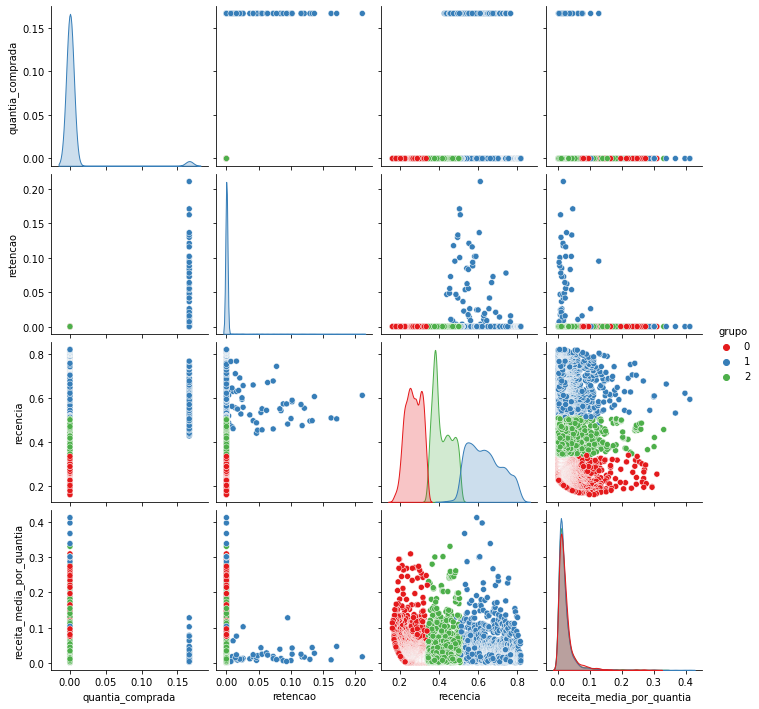

In [63]:
dataFrame2 = pd.concat([X, pd.Series(rfr2.predict(X))], axis=1, ignore_index=True)
dataFrame2.columns = dataFrame.columns

In [65]:
## Dataset + agrupamentos final

dataFrame['grupo'] = np.select(
    [
        dataFrame['grupo'] == 0,
        dataFrame['grupo'] == 1,
        dataFrame['grupo'] == 2,
    ],
    [
        'ouro',
        'bronze',
        'prata'
    ]
)

In [68]:
pd.concat([Cliente['cliente'], dataFrame], axis=1)#.to_csv(...)

,cliente,quantia_comprada,retencao,recencia,receita_media_por_quantia,grupo
0,32ea3bdedab835c3aa6cb68ce66565ef,0.133333,1.000000,0.090659,0.002646,ouro
1,ccafc1c3f270410521c3c6f3b249870f,0.066667,0.960443,0.119505,0.006896,ouro
2,d8f3c4f441a9b59a29f977df16724f38,0.066667,0.919304,0.012363,0.005102,ouro
3,94e5ea5a8c1bf546db2739673060c43f,0.066667,0.916139,0.159341,0.006151,ouro
4,87b3f231705783eb2217e25851c0a45d,0.066667,0.903481,0.166209,0.018453,ouro
...,...,...,...,...,...,...
95415,42c8ccbe558d063718d19cff01505af9,0.000000,0.000000,0.587912,0.018336,bronze
95416,42c837a3d7df8cfa87de63fbc1aade2f,0.000000,0.000000,0.054945,0.006541,ouro
95417,42c7e57c48d38fc34ed69508a092abcd,0.000000,0.000000,0.109890,0.009438,ouro
95418,42f3aebe1309a0f58863f1ec28898969,0.000000,0.000000,0.074176,0.002412,ouro
